# LSTM

_https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/_

### Setup

In [6]:
# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# models
import tensorflow as tf
print(tf.config.list_physical_devices())

# saving
import pickle

# misc
import numpy as np


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load Observations

                           airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00     -7.0         2.0     0.0          4.88   
2008-01-01 06:30:00+00:00     -7.5         3.0     0.0          4.88   
2008-01-01 06:45:00+00:00     -8.0         3.0     0.0          4.88   
2008-01-01 07:00:00+00:00     -7.5         1.9     0.0          4.88   
2008-01-01 07:15:00+00:00     -7.0         1.8     0.0          4.87   

                           107338_00010  
2008-01-01 06:15:00+00:00           1.9  
2008-01-01 06:30:00+00:00           1.9  
2008-01-01 06:45:00+00:00           1.9  
2008-01-01 07:00:00+00:00           1.9  
2008-01-01 07:15:00+00:00           1.9  


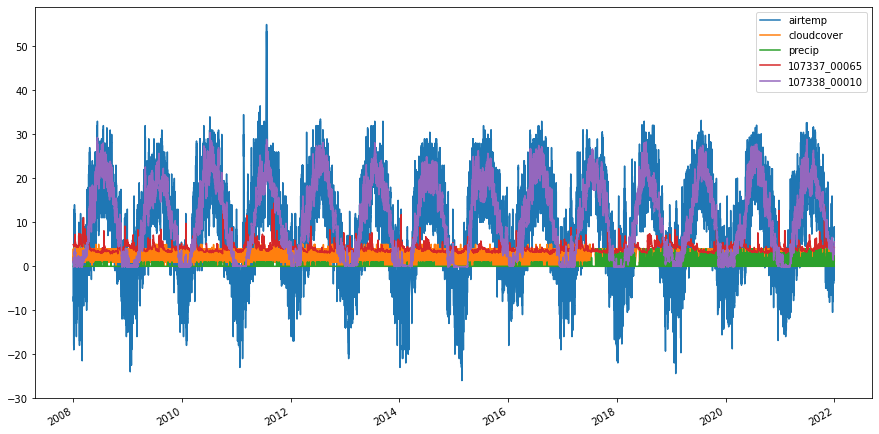

In [7]:
observations = pd.read_pickle('output/observations.pickle')

print(observations.head())
observations.plot()
plt.show()

### Prepare Dataframe for LSTM

In [8]:
values = observations.values

# ensure values are floats
values = values.astype('float')

# normalize features
in_values = values[:, 0:3]
out_values = values[:, 3:6]
in_scaler = MinMaxScaler(feature_range=(0, 1))
out_scaler = MinMaxScaler(feature_range=(0, 1))
in_scaled = in_scaler.fit_transform(in_values)
out_scaled = out_scaler.fit_transform(out_values)
scaled = pd.DataFrame(np.hstack((in_scaled, out_scaled)))

pickle.dump(in_scaler, open('output/in_scaler.pickle', 'wb'))
pickle.dump(out_scaler, open('output/out_scaler.pickle', 'wb'))

# ! revisit
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_in_vars=None, n_out=1, n_out_vars=None, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	if n_in_vars is None: n_in_vars = list(range(n_vars))
	if n_out_vars is None: n_out_vars = list(range(n_vars))
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[n_in_vars].shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in n_in_vars]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[n_out_vars].shift(-i))
		if i == 0:
			# cols.append(df.shift(-i))
			names += [('var%d(t)' % (j+1)) for j in n_out_vars]
		else:
			# cols.append(df[n_out_vars].shift(-i))
			names += [('var%d(t+%d)' % (j+1, i)) for j in n_out_vars]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# reframe data
# look back 2 days, forward 4
reframed = series_to_supervised(scaled, 4, None, 1, [0, 1, 2, 4])
print(reframed.head())

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4   0.234568       0.40        0.0   0.183074   0.071661   0.228395   
5   0.228395       0.60        0.0   0.183074   0.071661   0.222222   
6   0.222222       0.60        0.0   0.183074   0.071661   0.228395   
7   0.228395       0.38        0.0   0.183074   0.071661   0.234568   
8   0.234568       0.36        0.0   0.182211   0.071661   0.234568   

   var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var5(t-2)  var1(t-1)  \
4       0.60        0.0   0.183074   0.071661  ...   0.071661   0.228395   
5       0.60        0.0   0.183074   0.071661  ...   0.071661   0.234568   
6       0.38        0.0   0.183074   0.071661  ...   0.071661   0.234568   
7       0.36        0.0   0.182211   0.071661  ...   0.071661   0.240741   
8       0.34        0.0   0.182211   0.071661  ...   0.068404   0.246914   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  var2(t)  var3(t)  \
4       0.38        0.0   0.183074   0.

### Split Train/Test

In [9]:
values = reframed.values
train_portion = 0.8 # 80%
divider = int(len(values) * train_portion)

train = values[:divider, :]
test = values[divider:, :]

train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]

# reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(390220, 1, 23) (390220, 1) (97556, 1, 23) (97556, 1)


### Create Model

Epoch 1/100


2022-06-25 16:57:29.357177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 16:57:33.741008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 - 5s - loss: 0.3172 - val_loss: 0.2772 - 5s/epoch - 448ms/step
Epoch 2/100
12/12 - 4s - loss: 0.2136 - val_loss: 0.1521 - 4s/epoch - 354ms/step
Epoch 3/100
12/12 - 4s - loss: 0.1264 - val_loss: 0.0728 - 4s/epoch - 353ms/step
Epoch 4/100
12/12 - 4s - loss: 0.0541 - val_loss: 0.0512 - 4s/epoch - 354ms/step
Epoch 5/100
12/12 - 4s - loss: 0.0361 - val_loss: 0.0323 - 4s/epoch - 353ms/step
Epoch 6/100
12/12 - 4s - loss: 0.0276 - val_loss: 0.0253 - 4s/epoch - 353ms/step
Epoch 7/100
12/12 - 4s - loss: 0.0215 - val_loss: 0.0213 - 4s/epoch - 352ms/step
Epoch 8/100
12/12 - 4s - loss: 0.0183 - val_loss: 0.0203 - 4s/epoch - 351ms/step
Epoch 9/100
12/12 - 4s - loss: 0.0164 - val_loss: 0.0158 - 4s/epoch - 353ms/step
Epoch 10/100
12/12 - 4s - loss: 0.0122 - val_loss: 0.0140 - 4s/epoch - 355ms/step
Epoch 11/100
12/12 - 4s - loss: 0.0121 - val_loss: 0.0110 - 4s/epoch - 353ms/step
Epoch 12/100
12/12 - 4s - loss: 0.0117 - val_loss: 0.0204 - 4s/epoch - 352ms/step
Epoch 13/100
12/12 - 4s - loss: 0.012

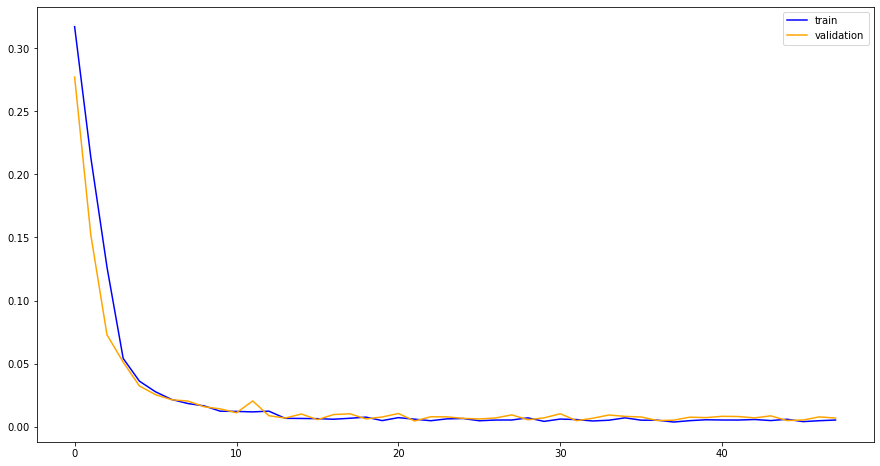

In [10]:
train = pd.DataFrame()
test = pd.DataFrame()
model = None
for i in range(1):
  # define model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(tf.keras.layers.LSTM(200, activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

  # fit
  history = model.fit(train_X,
                      train_y,
                      epochs=100,
                      batch_size=4*24*365, # process one year at a time to capture annual seasonality
                      validation_data=(test_X, test_y),
                      verbose=2,
                      shuffle=False,
                      callbacks=[callback])

  # record results
  train[str(i)] = history.history['loss']
  test[str(i)] = history.history['val_loss']

# save last model
model.save('output/model.h5')

plt.plot(train, color='blue', label='train')
plt.plot(test, color='orange', label='validation')
plt.legend()
plt.show()